In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def american_mc(S, K, sigma, r, T, M, option_type, payoff_func, q=0, num_sims=10_000):
    option_type = option_type.lower()
    if option_type != 'c' and option_type != 'p':
        return -1, -1

    dt = T / M
    dt_sqrt = np.sqrt(dt)
    discount = np.exp(-r * dt)

    stock_paths = np.zeros((num_sims, M+1))
    stock_paths[:, 0] = S

    for n in range(1, M+1):
        dW = np.random.standard_normal(num_sims) * dt_sqrt
        stock_paths[:, n] = stock_paths[:, n-1] * np.exp((r - q - 0.5 * sigma**2) * dt + sigma * dW)
    
    V = payoff_func(stock_paths[:, -1], K)

    for t in range(M - 1, 0, -1):
        if option_type == 'c':
            in_the_money = np.where(K < stock_paths[:, t])[0]
        if option_type == 'p':
            in_the_money = np.where(K > stock_paths[:, t])[0]
        if len(in_the_money) == 0:
            continue

        X = stock_paths[in_the_money, t]
        Y = V[in_the_money] * discount

        A = np.vstack([np.ones(len(X)), X, X**2]).T
        coeffs = np.linalg.lstsq(A, Y, rcond=None)[0]
        continuation = coeffs[0] + coeffs[1]*X + coeffs[2]*X**2

        if option_type == 'c':
            exercise = X - K
        if option_type == 'p':
            exercise = K - X
        V[in_the_money] = np.where(exercise > continuation, exercise, V[in_the_money] * discount)
        V[~np.isin(np.arange(num_sims), in_the_money)] *= discount

    return stock_paths, np.mean(V) * np.exp(-r * dt)

In [3]:
S = 100
K = 100
T = 1.0
sigma = 0.3
r = 0.05
M = 252

In [4]:
def call_payoff(S, K):
    return np.maximum(S - K, 0)

def put_payoff(S, K):
    return np.maximum(K - S, 0)

In [5]:
paths, call_price = american_mc(S, K, sigma, r, T, M, 'c', call_payoff, num_sims=1_000_000)
f"American Call Price: ${call_price.round(4)}"

'American Call Price: $13.9955'

In [6]:
paths, put_price = american_mc(S, K, sigma, r, T, M, 'p', put_payoff, num_sims=1_000_000)
f"American Put Price: ${put_price.round(4)}"

'American Put Price: $9.8255'

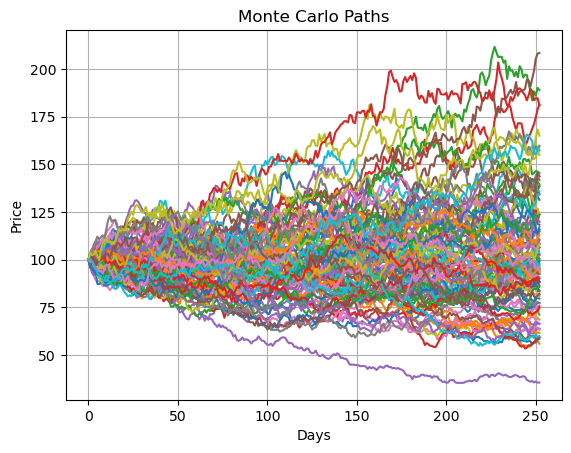

In [7]:
for i in range(100):
    plt.plot(paths[i], label=f'Path {i+1}')
plt.xlabel("Days")
plt.ylabel("Price")
plt.title("Monte Carlo Paths")
# plt.legend()
plt.grid(True)
plt.show()